# Pull out basic statistics about void life
Use our matched voids to show a few things about how voids move and change

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from pathlib import Path
import pandas as pd
import numpy as np

Configuration

In [2]:
run_path = Path('../../runs/drift-corrected-625C/')
pixel_size = 0.47  # nm/pixel

## Load in the Void Data
Load in the void tracks from a previous notebook and the overall summaries in each

In [3]:
void_tracks = pd.read_json(run_path / 'void_tracks.json')
void_tracks.head(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,25,26,23,"[[3.7627118644, 745.3389830508], [3.8007532957...","[0, None, None, None, None, None, None, None, ...","[0.0, 0.0476965592, 0.0953931185, 0.1430896777...",2.695101,0.103658,"[0.0, 0.0476965592, 0.0953931185, 0.1430896777...",3.790152,0.145775,"[4.3336224207, 4.3211095789, 4.3085967371, 4.2...",4.333622,4.145930,-0.012513
1,0,338,339,123,"[[493.6526946108, 266.8922155689], [492.622950...","[34, 38, 41, 34, 34, 37, 32, None, None, None,...","[0.0, 1.2335113262, 2.0486717212, 2.3058971942...",17.745102,0.052345,"[0.0, 1.2335113262, 2.2319189786, 3.089721106,...",465.101293,1.371980,"[7.290936222, 6.2316776324, 6.6755811781, 5.64...",7.290936,3.989423,0.000141


In [4]:
frame_data = pd.read_json(run_path / 'frame_data.json')
frame_data.head(2)

,void_frac,void_count,radii,radii_average,positions,run_time,created_time,completed_time,mask-path,image-path,rtt,detect_time,frame
0,0.027991,63,"[4.3336224207, 10.5550206141, 21.6019048499, 4...",10.117077,"[[3.7627118644, 745.3389830508], [7.5828571429...",0.316171,2023-04-20 12:50:41.216,2023-04-26 18:45:39.257,frames/masks/frame-0000.tiff,frames/frame-0000.tiff,12.662785,2023-04-26 18:45:26.594,0
1,0.029202,76,"[10.7935822757, 21.468877828, 4.7539459314, 7....",9.324464,"[[7.8169398907000005, 870.9972677596], [30.921...",0.313740,2023-04-20 12:50:41.216,2023-04-26 18:47:09.517,frames/masks/frame-0001.tiff,frames/frame-0001.tiff,102.920291,2023-04-26 18:45:26.596,1


## Evaluate Growth of Individual Voids
Determine if there are rules which govern the mobility and growth of voids

### Coarse Metrics
Are they growing or shrinking over their whole life?

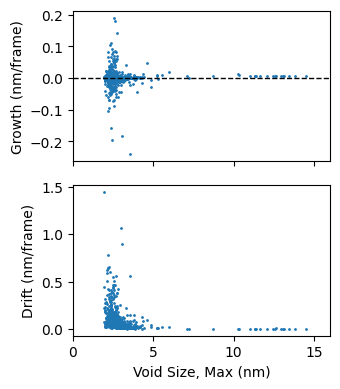

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 4.), sharex=True)

# Plot the void growth
ax = axs[0]
ax.scatter(void_tracks['max_radius'] * pixel_size, void_tracks['growth_rate'] * pixel_size, s=1)
ax.set_xlim(0, 16)
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth (nm/frame)')

# Plot the movement
ax = axs[1]
ax.scatter(void_tracks['max_radius'] * pixel_size, void_tracks['drift_rate'] * pixel_size, s=1)
ax.set_ylabel('Drift (nm/frame)')

ax.set_xlabel('Void Size, Max (nm)')
fig.tight_layout()

fig.savefig('figures/coarse-metrics.png', dpi=320)

Large voids continue to continue to grow, small ones will disappear. Drift (how much it moved from the start) is only noticable for the small voids

### Does that hold on at individual timesteps?
Can we look at specific snapshots in time and see if smaller voids are more mobile and less likely to grow.

Our strategy will be to fit a smoothing spline to the positions and radii, then estimate the derivatives at a few points along its timeline.

Start by examining a few voids

In [6]:
big_void = void_tracks.sort_values('max_radius', ascending=False).iloc[0]

In [7]:
medium_void = void_tracks.sort_values('max_radius', ascending=False).iloc[25]

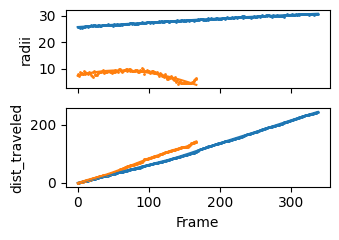

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.5), sharex=True)

for c, ax in zip(['radii', 'dist_traveled'], axs):
    ax.set_ylabel(c)
    for void in [big_void, medium_void]:
        x = np.arange(void['total_frames']) + void['start_frame']
        spline = UnivariateSpline(x, void[c])
        ax.scatter(x, void[c], s=1)
        ax.plot(x, spline(x))
    
axs[-1].set_xlabel('Frame')
fig.tight_layout()

The spline works well with its default settings.

Repeat analysis for all voids then pick the derivatives at a few frames along the growth

In [9]:
void

start_frame                                                        0
end_frame                                                        167
total_frames                                                     168
inferred_frames                                                   18
positions          [[756.5970149254, 517.5273631841], [756.739795...
local_id           [44, 54, 53, 49, 47, 53, 48, 47, 42, 52, 48, 4...
disp_from_start    [0.0, 0.3627658741, 0.9657923489, 0.6954128137...
max_disp                                                   15.366779
drift_rate                                                  0.091469
dist_traveled      [0.0, 0.3627658741, 0.9694119525, 1.2506030168...
total_traveled                                            141.356051
movement_rate                                               0.841405
radii              [7.9987678503, 7.8986541697, 7.484820637, 8.66...
max_radius                                                 10.387832
min_radius                        

In [10]:
snapshots = []
for _, void in void_tracks.query('total_frames > 32').iterrows():
    # Get the rates of changes of voids wrt time
    x = np.arange(void['total_frames']) + void['start_frame']
    r_spline = UnivariateSpline(x, void['radii'])
    m_spline = UnivariateSpline(x, void['dist_traveled']).derivative(1)
    
    # Measure it every 20 frames
    r_spline_dt = r_spline.derivative(1)
    for frame in x[::20]:
        snapshots.append({
            'void': void.name,
            'frame': frame,
            'radius': r_spline(frame),
            'radius_dt': r_spline_dt(frame),
            'movement': m_spline(frame)
        })
snapshots = pd.DataFrame(snapshots).sample(frac=1)
print(f'Pulled {len(snapshots)} snapshots')

Pulled 2486 snapshots


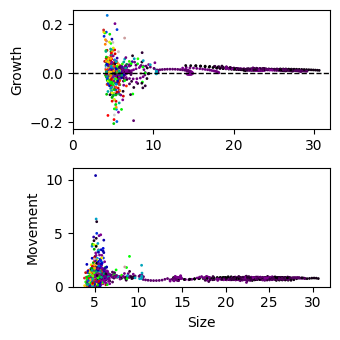

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 3.5))

ax = axs[0]
ax.scatter(snapshots['radius'], snapshots['radius_dt'], s=1, c=snapshots['void'], cmap='nipy_spectral')
ax.set_xlim(0, max(ax.get_xlim()))
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)
ax.set_ylabel('Growth')

ax = axs[1]
ax.scatter(snapshots['radius'], snapshots['movement'], s=1, c=snapshots['void'], cmap='nipy_spectral')
ax.set_ylim(0, max(ax.get_ylim()))
ax.set_ylabel('Movement')

ax.set_xlabel('Size')
fig.tight_layout()
fig.savefig('figures/time-resolved-voids.png')

The small ones are the ones growing rapidly and shrinking

In [12]:
snapshots.to_csv(run_path / 'void_snapshots.csv', index=False)

## Change in Distribution over Time
We start with a bimodal distribution and it becomes clearer over time

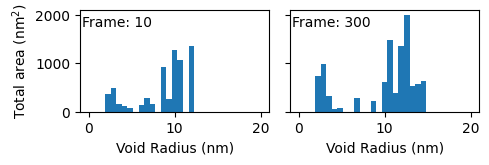

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(5., 1.75), sharey=True, sharex=True)

bins = np.linspace(0, 20, 32)
for fid, ax in zip([10, 300], axs):
    radii = np.multiply(frame_data.loc[fid]['radii'], pixel_size)
    area = np.pi * radii ** 2
    ax.hist(radii, bins=bins, weights=area)
    ax.set_xlabel('Void Radius (nm)')
    ax.text(0.01, 0.95, f'Frame: {fid}', transform=ax.transAxes, ha='left', va='top')
axs[0].set_ylabel('Total area (nm$^2$)')

fig.tight_layout()
fig.savefig('figures/radius-histogram.png', dpi=320)